<a href="https://colab.research.google.com/github/ramisa7/Deep-Learning/blob/main/Ramisa_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it.

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import seaborn as sns


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python.

In [2]:
import requests

def download_text(url):
    response = requests.get(url)
    return response.text

author1_text = download_text("https://www.gutenberg.org/cache/epub/73496/pg73496.txt") # an eye for the ladies by ny
author2_text = download_text("https://www.gutenberg.org/cache/epub/73490/pg73490.txt") # the blwing away by edith


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [3]:
print( len(author1_text))
print(len(author2_text))

47497
41041


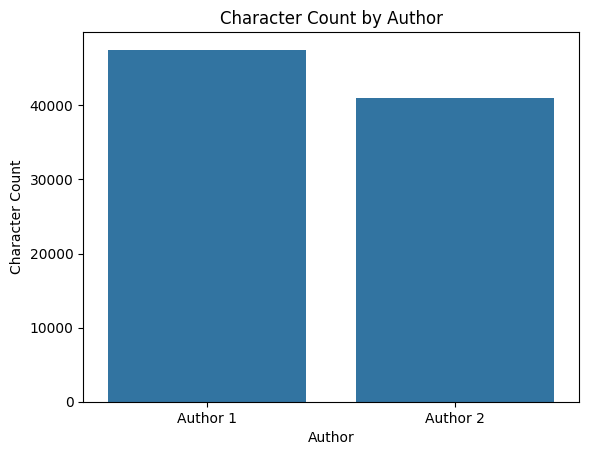

In [4]:
import pandas as pd

# Create a DataFrame with author names and their text lengths
data = pd.DataFrame({'Author': ['Author 1', 'Author 2'],
                     'Character Count': [len(author1_text), len(author2_text)]})

# Plot the character count by author
sns.barplot(data=data, x='Author', y='Character Count')
plt.title('Character Count by Author')
plt.xlabel('Author')
plt.ylabel('Character Count')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author.

Later you may change sequence_length to achieve better results!

In [5]:
def one_hot_encode(text):
    alphabet = sorted(set(text))
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    encoded_text = [char_to_int[char] for char in text]
    one_hot_encoded = np.eye(len(alphabet))[encoded_text]
    return one_hot_encoded, char_to_int, int_to_char

author1_encoded, _, _ = one_hot_encode(author1_text)
author2_encoded, _, _ = one_hot_encode(author2_text)


In [6]:
def create_sequences(encoded_text, sequence_length):
    sequences = []
    for i in range(len(encoded_text) - sequence_length):
        sequences.append(encoded_text[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 60
author1_sequences = create_sequences(author1_encoded, sequence_length)
author2_sequences = create_sequences(author2_encoded, sequence_length)

# Add labels
author1_labels = np.zeros((len(author1_sequences), 1))
author2_labels = np.ones((len(author2_sequences), 1))

# Combine sequences and labels
X = np.concatenate((author1_sequences, author2_sequences), axis=0)
y = np.concatenate((author1_labels, author2_labels), axis=0)


In [7]:
# check to ensure the shapes are correct & data is balanced

print("Shape of Author 1 sequences:", author1_sequences.shape)
print("Shape of Author 2 sequences:", author2_sequences.shape)

# Check the shape of the labels array
print("Shape of labels array:")
print(y.shape)

# Check for data balance
author1_count = np.sum(y == 0)
author2_count = np.sum(y == 1)
print(f"Author 1 count: {author1_count}, Author 2 count: {author2_count}")



Shape of Author 1 sequences: (47437, 60, 91)
Shape of Author 2 sequences: (40981, 60, 91)
Shape of labels array:
(88418, 1)
Author 1 count: 47437, Author 2 count: 40981


## Data splitting
Split the data into train, validate and test sets. Make

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [9]:
model = Sequential([
    LSTM(128, input_shape=(sequence_length, X.shape[2])),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


C:\Users\ramis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Model training
Train the model and apply early stopping.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=3, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 68s 58ms/step - accuracy: 0.9653 - loss: 0.0941 - val_accuracy: 0.9880 - val_loss: 0.0181
Epoch 2/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 64s 57ms/step - accuracy: 0.9877 - loss: 0.0339 - val_accuracy: 0.9947 - val_loss: 0.0122
Epoch 3/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.9945 - loss: 0.0148 - val_accuracy: 0.9920 - val_loss: 0.0207
Epoch 4/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.9900 - val_loss: 0.0380
Epoch 5/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 79s 72ms/step - accuracy: 0.9910 - loss: 0.0251 - val_accuracy: 0.9939 - val_loss: 0.0122
Epoch 6/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 85s 77ms/step - accuracy: 0.9949 - loss: 0.0109 - val_accuracy: 0.9852 - val_loss: 0.0258
Epoch 7/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - accuracy: 0.9914 - loss: 0.0203 - val_accuracy: 0.9926 - val_loss: 0.0141
Epoch 8/20
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.9945 -

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [11]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9938 - loss: 0.0140
Test Loss: 0.01204637810587883, Test Accuracy: 0.9942320585250854


## Confusion matrix
Calculate and display the confusion matrix.

In [14]:
from sklearn.metrics import confusion_matrix

print( X_test.shape)

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int')

cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)


(8842, 60, 91)
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Confusion Matrix:
[[4732   49]
 [   2 4059]]


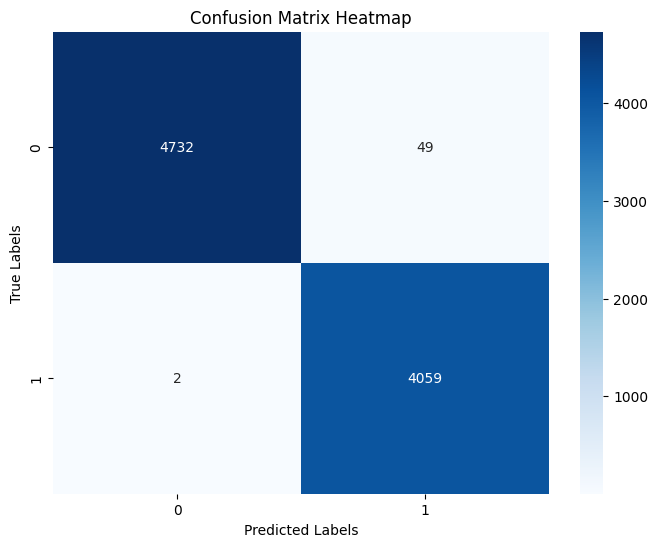

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)

# Set labels, title, and axis ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix Heatmap')

# Show the plot
plt.show()
